In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from Model import Model
from PlaceInputs import PlaceInputs2D
from utils import *
import configs

# Initialize RNN

In [2]:
# Parameters
arena_width_in_states = 10

In [3]:
num_states = arena_width_in_states**2
N_inp = N_bar = (arena_width_in_states*(arena_width_in_states+1))**2
place_inputs = PlaceInputs2D(N_inp, num_states).get_inputs()
arena_width_in_input_units = int(np.sqrt(N_inp))
model = Model(
    N_inp, N_bar, num_states, #plasticity_bias=-0.45,
    rec_strength=3,
    narrow_search_factor=0.5, wide_search_factor=1.,
    )

Place inputs generated from arena with width 10


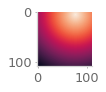

In [4]:
cache_state = 7
plt.figure(figsize=(1,1))
plt.imshow(place_inputs[cache_state].reshape(arena_width_in_input_units, arena_width_in_input_units))
plt.show()

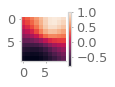

In [5]:
plt.figure(figsize=(1,1))
plt.imshow(np.corrcoef(place_inputs)[7].reshape((arena_width_in_states,arena_width_in_states)))
plt.colorbar()
plt.show()

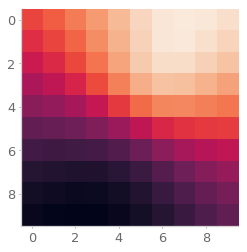

In [6]:
plt.imshow(np.corrcoef(place_inputs)[7].reshape((arena_width_in_states,arena_width_in_states)))

# Learning without skew

In [7]:
identification_s = 0.2

Now I just cached at location: 7


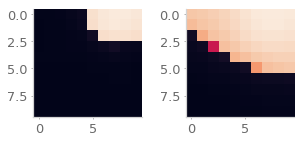

In [8]:
cache_identification = []
narrow_recall = []
wide_recall = []

model.reset()]
    
print("I just cached at location:", cache_state)
preacts, acts, _, acts_over_time = model.run_recurrent(place_inputs)
model.update(place_inputs[cache_state], acts[cache_state], preacts[cache_state])

_, _, _cache_identification, _ = model.run_recall(identification_s, place_inputs)
_cache_identification[np.isnan(_cache_identification)] = 0
identification_readout = np.linalg.norm(_cache_identification, axis=1)
identification_readout /= identification_readout.max()

_, _, _wide_recall, _ = model.run_wide_recall(place_inputs)
_wide_recall[np.isnan(_wide_recall)] = 0
wide_readout = np.linalg.norm(_wide_recall, axis=1)
wide_readout /= wide_readout.max()

fig, axs = plt.subplots(1, 2, figsize=(5, 2))
axs[0].imshow(identification_readout.reshape(arena_width_in_states, arena_width_in_states))
axs[1].imshow(wide_readout.reshape(arena_width_in_states, arena_width_in_states))
plt.show()

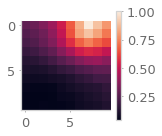

In [9]:
plt.figure(figsize=(2,2))
plt.imshow(np.corrcoef(acts)[7].reshape((arena_width_in_states,arena_width_in_states)))
plt.colorbar()
plt.show()

In [10]:
model.reset()

# Add predictive skew to RNN weights

In [11]:
old_J = model.J_xx.copy()

In [ ]:
xx = 0

In [26]:
def get_state(x, y):
    if (x < 0) or (x>=arena_width_in_input_units):
        return -1
    elif (y < 0) or (y>=arena_width_in_input_units):
        return -1
    else:
        return x*arena_width_in_input_units + y

In [181]:
# Define T matrix in state space
T = np.eye(N_inp)*0.25
c = cache_state
c_in_units = int((c/num_states)*N_inp)

# Add adjacent transitions
for a in range(N_inp): # From
    a_x = a // arena_width_in_input_units; a_y = a % arena_width_in_input_units;
    from_state = get_state(a_x, a_y)
    for to_x in range(-2, 3):
        for to_y in range(-2, 3):
            b_x = a_x + to_x; b_y = a_y + to_y
            b = get_state(b_x, b_y)
            if b == -1: continue
            T[a,b] = 0.25

# Add path-directed transitions
c_x = c_in_units // arena_width_in_input_units
c_y = c_in_units % arena_width_in_input_units
for to_x in c_x+np.arange(50):
    for from_x in to_x+np.arange(15):
        for y_offset in np.arange(-3,4):
            to_state = get_state(to_x, c_y)
            from_state = get_state(from_x, c_y+y_offset)
            print(f'{to_state} to {from_state}')
            T[from_state, to_state] = 0.75
T = T/np.sum(T, axis=1)[:,np.newaxis]

847 to 844
847 to 845
847 to 846
847 to 847
847 to 848
847 to 849
847 to 850
847 to 954
847 to 955
847 to 956
847 to 957
847 to 958
847 to 959
847 to 960
847 to 1064
847 to 1065
847 to 1066
847 to 1067
847 to 1068
847 to 1069
847 to 1070
847 to 1174
847 to 1175
847 to 1176
847 to 1177
847 to 1178
847 to 1179
847 to 1180
847 to 1284
847 to 1285
847 to 1286
847 to 1287
847 to 1288
847 to 1289
847 to 1290
847 to 1394
847 to 1395
847 to 1396
847 to 1397
847 to 1398
847 to 1399
847 to 1400
847 to 1504
847 to 1505
847 to 1506
847 to 1507
847 to 1508
847 to 1509
847 to 1510
847 to 1614
847 to 1615
847 to 1616
847 to 1617
847 to 1618
847 to 1619
847 to 1620
847 to 1724
847 to 1725
847 to 1726
847 to 1727
847 to 1728
847 to 1729
847 to 1730
847 to 1834
847 to 1835
847 to 1836
847 to 1837
847 to 1838
847 to 1839
847 to 1840
847 to 1944
847 to 1945
847 to 1946
847 to 1947
847 to 1948
847 to 1949
847 to 1950
847 to 2054
847 to 2055
847 to 2056
847 to 2057
847 to 2058
847 to 2059
847 to 2060
847 to

2937 to 3705
2937 to 3706
2937 to 3707
2937 to 3708
2937 to 3709
2937 to 3710
2937 to 3814
2937 to 3815
2937 to 3816
2937 to 3817
2937 to 3818
2937 to 3819
2937 to 3820
2937 to 3924
2937 to 3925
2937 to 3926
2937 to 3927
2937 to 3928
2937 to 3929
2937 to 3930
2937 to 4034
2937 to 4035
2937 to 4036
2937 to 4037
2937 to 4038
2937 to 4039
2937 to 4040
2937 to 4144
2937 to 4145
2937 to 4146
2937 to 4147
2937 to 4148
2937 to 4149
2937 to 4150
2937 to 4254
2937 to 4255
2937 to 4256
2937 to 4257
2937 to 4258
2937 to 4259
2937 to 4260
2937 to 4364
2937 to 4365
2937 to 4366
2937 to 4367
2937 to 4368
2937 to 4369
2937 to 4370
2937 to 4474
2937 to 4475
2937 to 4476
2937 to 4477
2937 to 4478
2937 to 4479
2937 to 4480
3047 to 3044
3047 to 3045
3047 to 3046
3047 to 3047
3047 to 3048
3047 to 3049
3047 to 3050
3047 to 3154
3047 to 3155
3047 to 3156
3047 to 3157
3047 to 3158
3047 to 3159
3047 to 3160
3047 to 3264
3047 to 3265
3047 to 3266
3047 to 3267
3047 to 3268
3047 to 3269
3047 to 3270
3047 to 3374

5797 to 7008
5797 to 7009
5797 to 7010
5797 to 7114
5797 to 7115
5797 to 7116
5797 to 7117
5797 to 7118
5797 to 7119
5797 to 7120
5797 to 7224
5797 to 7225
5797 to 7226
5797 to 7227
5797 to 7228
5797 to 7229
5797 to 7230
5797 to 7334
5797 to 7335
5797 to 7336
5797 to 7337
5797 to 7338
5797 to 7339
5797 to 7340
5907 to 5904
5907 to 5905
5907 to 5906
5907 to 5907
5907 to 5908
5907 to 5909
5907 to 5910
5907 to 6014
5907 to 6015
5907 to 6016
5907 to 6017
5907 to 6018
5907 to 6019
5907 to 6020
5907 to 6124
5907 to 6125
5907 to 6126
5907 to 6127
5907 to 6128
5907 to 6129
5907 to 6130
5907 to 6234
5907 to 6235
5907 to 6236
5907 to 6237
5907 to 6238
5907 to 6239
5907 to 6240
5907 to 6344
5907 to 6345
5907 to 6346
5907 to 6347
5907 to 6348
5907 to 6349
5907 to 6350
5907 to 6454
5907 to 6455
5907 to 6456
5907 to 6457
5907 to 6458
5907 to 6459
5907 to 6460
5907 to 6564
5907 to 6565
5907 to 6566
5907 to 6567
5907 to 6568
5907 to 6569
5907 to 6570
5907 to 6674
5907 to 6675
5907 to 6676
5907 to 6677

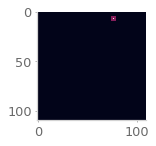

In [182]:
plt.figure(figsize=(2,2)) # Where is cache going to?
plt.imshow(
    T[c_in_units,:].reshape(
        (arena_width_in_input_units, arena_width_in_input_units)))
plt.show()

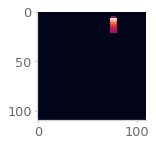

In [183]:
plt.figure(figsize=(2,2)) # What is going to cache?
plt.imshow(
    T[:,c_in_units].reshape(
        (arena_width_in_input_units, arena_width_in_input_units)))
plt.show()

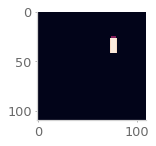

In [184]:
plt.figure(figsize=(2,2)) # What is on path to cache?
plt.imshow(
    T[:,get_state(c_x+20,c_y)].reshape(
        (arena_width_in_input_units, arena_width_in_input_units)))
plt.show()

In [185]:
model.J_xx = old_J.copy()

In [186]:
model.J_xx += T*2

# RNN activity under different recurrent strengths
(Black line indicates the identity line)

#### $r=0$

In [187]:
_, acts0, _, _ = model.run_recurrent_r(place_inputs, 0.)

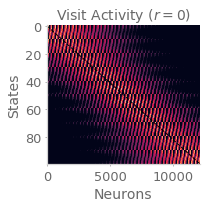

In [188]:
plt.figure(figsize=(3,3))
plt.imshow(acts0, aspect='auto')
plt.plot([0,N_bar-1], [0,num_states-1], color='black', linestyle='--')
plt.xlabel('Neurons')
plt.ylabel('States')
plt.title(f"Visit Activity ($r=0$)")
plt.tight_layout()
plt.show()

#### $r=0.3$

In [189]:
_, acts03, _, _ = model.run_recurrent_r(place_inputs, 0.3)

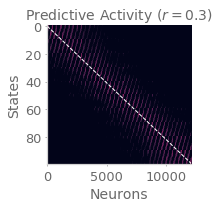

In [190]:
plt.figure(figsize=(3,3))
plt.imshow(acts03, aspect='auto')
plt.plot([0,N_bar-1], [0,num_states-1], color='white', linestyle='--')
plt.xlabel('Neurons')
plt.ylabel('States')
plt.title(f"Predictive Activity ($r=0.3$)")
plt.tight_layout()
plt.show()

#### $r=1.0$

In [191]:
_, acts1, _, _ = model.run_recurrent_r(place_inputs, 1.0)

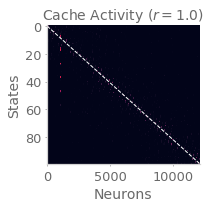

In [192]:
plt.figure(figsize=(3,3))
plt.imshow(acts1, aspect='auto')
plt.plot([0,N_bar-1], [0,num_states-1], color='white', linestyle='--')
plt.xlabel('Neurons')
plt.ylabel('States')
plt.title(f"Cache Activity ($r=1.0$)")
plt.tight_layout()
plt.show()

# Learning with skew

Now I just cached at location: 7


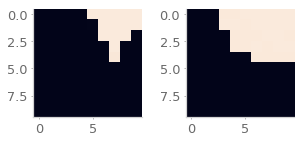

In [193]:
cache_identification = []
narrow_recall = []
wide_recall = []

for c_idx, cache_state in enumerate(cache_states):
    
    print("Now I just cached at location:", cache_state)
    preacts, acts, _, acts_over_time = model.run_recurrent(place_inputs)
    model.update(place_inputs[cache_state], acts[cache_state], preacts[cache_state])

    _, _, _cache_identification, _ = model.run_recall(identification_s, place_inputs)
    _cache_identification[np.isnan(_cache_identification)] = 0
    identification_readout = np.linalg.norm(_cache_identification, axis=1)
    identification_readout /= identification_readout.max()
    
    _, _, _wide_recall, _ = model.run_wide_recall(place_inputs)
    _wide_recall[np.isnan(_wide_recall)] = 0
    wide_readout = np.linalg.norm(_wide_recall, axis=1)
    wide_readout /= wide_readout.max()

    fig, axs = plt.subplots(1, 2, figsize=(5, 2))
    axs[0].imshow(identification_readout.reshape(arena_width_in_states, arena_width_in_states))
    axs[1].imshow(wide_readout.reshape(arena_width_in_states, arena_width_in_states))
    plt.show()

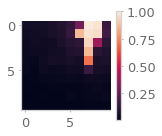

In [194]:
plt.figure(figsize=(2,2))
plt.imshow(np.corrcoef(acts)[7].reshape((arena_width_in_states,arena_width_in_states)))
plt.colorbar()
plt.show()